In [21]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sktime.datasets import load_from_tsfile_to_dataframe


In [24]:
CURR_DIR = Path.cwd()
CURR_DIR_PARENT = list(CURR_DIR.parents)
SRC_DIR = CURR_DIR_PARENT[0]
DATA_DIR = os.path.join(SRC_DIR,'data')
DATASET_DIR = os.path.join(DATA_DIR,'ECG5000')
train_path = os.path.join(DATASET_DIR,"ECG5000_TRAIN.ts")
test_path  = os.path.join(DATASET_DIR,"ECG5000_TEST.ts")

In [26]:

# X_train, X_test : DataFrame où chaque cellule contient une série numpy (dim == n_timesteps)
X_train, y_train = load_from_tsfile_to_dataframe(train_path)
X_test,  y_test = load_from_tsfile_to_dataframe(test_path)

print("X_train shape:", X_train.shape)
print("X_test shape" , X_test.shape)
print("Example series shape:", X_train.iloc[0,0].shape)

# Convert to numpy arrays shape: (N, T, F)
def df_to_numpy(X):
    # Suppose univarié (F=1). Pour multivarié, concatène les colonnes.
    arr = np.stack([X.iloc[i,0] for i in range(len(X))], axis=0)
    return arr[..., np.newaxis]  # (N, T, 1)

X_train_np = df_to_numpy(X_train)
X_test_np  = df_to_numpy(X_test)


X_train shape: (500, 1)
X_test shape (4500, 1)
Example series shape: (140,)


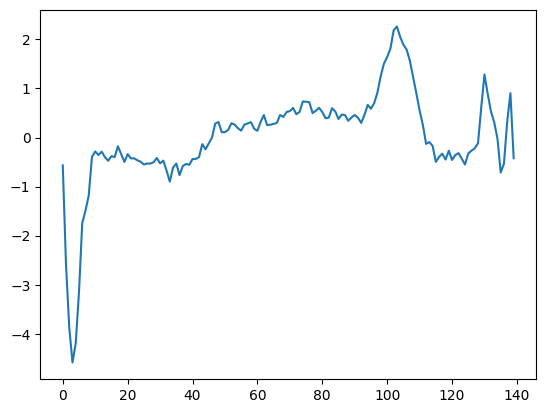

In [28]:
plt.plot(X_train_np[2])


In [29]:
X_train_torch = torch.from_numpy(X_train_np).float()
X_test_torch = torch.from_numpy(X_test_np).float()
y_train_torch = torch.from_numpy(y_train.astype(np.int64))
y_test_torch = torch.from_numpy(y_test.astype(np.int64))



In [30]:

# Dataset
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,      # on mélange pour le train
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,     # on ne mélange pas pour le test
    drop_last=False,
)


In [31]:
uuu = iter(train_loader)
x,y = next(uuu)
print(x.shape,y.shape)



torch.Size([2, 140, 1]) torch.Size([2])


In [32]:
class ResBlock(nn.Module):
    def __init__(self, channel, dilation, kernel_size):
        super().__init__()

        self.conv1 = nn.Conv1d(
            channel, channel,
            dilation=dilation,
            kernel_size=kernel_size,
            padding="same"  
        )
        self.conv2 = nn.Conv1d(
            channel, channel,
            dilation=dilation,
            kernel_size=kernel_size,
            padding="same"
        )
        self.relu = nn.ReLU()  

    def forward(self, x):
        # x : (B, K, t)
        # print(x.shape)
        res = x
        h = self.conv1(x)          # (B, K, t)
        h = self.relu(h)         
        h = self.conv2(h)          # (B, K, t)
        out = self.relu(h + res)   
        # print(out.shape)
        return out
    
# prend en input un batch de sous séquences (B,C,t) avec t = % T
# Ressord un (B,K,t) 

class Encoder(nn.Module):
    def __init__(self,in_channel=1,representation_dim=8,num_blocks = 10,kernel_size = 3):
        super().__init__()
        
        
        self.representation_dim = representation_dim
        self.num_blocks = num_blocks
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        
        # MLP per timestamp = Conv1D
        self.input_proj_layer = nn.Conv1d(in_channel,representation_dim,kernel_size=1,)

        # on définit les resBlocks avec dilatation : 
        blocks = []
        for i in range(num_blocks):
            bi = ResBlock(channel=self.representation_dim,dilation = 2**(i+1),kernel_size=self.kernel_size)
            blocks.append(bi
            )
        self.blocks = nn.Sequential(*blocks)
        
    def forward(self,x):
        # x : (B,C,t) C=1 en univarié
        # print(x.shape)
        z = self.input_proj_layer(x)
        # print(z.shape) # z : (B,K,t) avec K dimension de représentation
        r = self.blocks(z) # (B,K,t)
        return r
            
        


In [33]:
import torch
import torch.nn.functional as F


def InstanceLoss(r1, r2):
    """
    r1, r2 : (B, K, T)
    Adaptation directe de instance_contrastive_loss de TS2Vec
    (qui attend (B, T, C)).
    """
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    if B == 1:
        # même logique : pas de contraste inter-instance possible
        return r1.new_tensor(0.)

    # on passe en (B, T, C) = (B, T, K)
    z1 = r1.permute(0, 2, 1)  # (B, T, K)
    z2 = r2.permute(0, 2, 1)  # (B, T, K)

    # --- copie quasi-littérale du code TS2Vec ---
    B, T, C = z1.size()
    z = torch.cat([z1, z2], dim=0)   # 2B x T x C
    z = z.transpose(0, 1)            # T x 2B x C
    sim = torch.matmul(z, z.transpose(1, 2))  # T x 2B x 2B

    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # T x 2B x (2B-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2
    # --- fin copie ---

    return loss


def TimeLoss(r1, r2):
    """
    r1, r2 : (B, K, T)
    Adaptation directe de temporal_contrastive_loss de TS2Vec
    (qui attend (B, T, C)).
    """
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    if T == 1:
        # pas de contraste temporel possible
        return r1.new_tensor(0.)

    # on passe en (B, T, C) = (B, T, K)
    z1 = r1.permute(0, 2, 1)  # (B, T, K)
    z2 = r2.permute(0, 2, 1)  # (B, T, K)

    # --- copie quasi-littérale du code TS2Vec ---
    z = torch.cat([z1, z2], dim=1)   # B x 2T x C
    sim = torch.matmul(z, z.transpose(1, 2))  # B x 2T x 2T

    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # B x 2T x (2T-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2
    # --- fin copie ---

    return loss


def HierLoss(r1, r2, alpha: float = 0.5, temporal_unit: int = 0):
    """
    Version (B, K, T) de hierarchical_contrastive_loss.

    r1, r2 : (B, K, T)
    alpha : poids de l'instance loss vs time loss (comme TS2Vec)
    temporal_unit : profondeur minimale pour activer le time loss
    """
    assert r1.shape == r2.shape
    loss = r1.new_tensor(0.)
    d = 0

    # ici la dimension temporelle est r1.size(2)
    while r1.size(2) > 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        if d >= temporal_unit and (1 - alpha) != 0:
            loss += (1 - alpha) * TimeLoss(r1, r2)
        d += 1

        # pooling hiérarchique le long de T (dim=2) comme tu faisais
        r1 = F.max_pool1d(r1, kernel_size=2)  # (B, K, T//2)
        r2 = F.max_pool1d(r2, kernel_size=2)

    # niveau final T == 1 : seulement instance loss comme dans TS2Vec
    if r1.size(2) == 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        d += 1

    return loss / d


### Trainning : 

In [34]:
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

model = Encoder(in_channel=1, representation_dim=320, num_blocks=10, kernel_size=3)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


N_EPOCH = 300
LogList = []

for epoch in range(N_EPOCH):
    for x, y in train_loader:
        optimizer.zero_grad()
       
        # x : (B, T, 1)  to (B, 1, T)
        x = x.permute(0, 2, 1).contiguous()
        B, C, T = x.shape

        tau = np.random.random()
        L = int(tau * T)

        if L < 2:
            continue  

        # deux fenêtres [a1, a1+L], [a2, a2+L]
        a1 = np.random.randint(0, T - L + 1)
        a2 = np.random.randint(0, T - L + 1)
        end1 = a1 + L
        end2 = a2 + L
        
        # on calcule l’overlap dans la timeline globale
        inter_start = max(a1, a2)
        inter_end   = min(end1, end2)
        L_ov = inter_end - inter_start
        
        # pas de vraie overlap donc on saute ce batch
        if L_ov < 2:
            continue
        
         # offsets locaux dans chaque crop (dans la dimension temps)
        offset1 = inter_start - a1
        offset2 = inter_start - a2
        
        
        x1 = x[:, :, a1:end1]  # (B, 1, L)
        x2 = x[:, :, a2:end2]  # (B, 1, L)

        # passage dans le modèle
        r1 = model(x1)  # (B, K, L)
        r2 = model(x2)  # (B, K, L)

    
        # on tronque les représentations à la partie overlappée alignée
        r1_ov = r1[:, :, offset1:offset1+L_ov]  # (B, K, L_ov)
        r2_ov = r2[:, :, offset2:offset2+L_ov]  # (B, K, L_ov)

        # la HierLoss ne voit que la partie commune, alignée en t
        Loss = HierLoss(r1_ov, r2_ov)
        print("Loss:", Loss.item())

        Loss.backward()
        optimizer.step()

        LogList.append(Loss.item())

    torch.save(model.state_dict(), os.path.join(CURR_DIR, "model.pt"))

Loss: 7.050447940826416
Loss: 11.432387351989746
Loss: 7.696142196655273
Loss: 7.950714111328125
Loss: 6.097126483917236
Loss: 8.00769329071045
Loss: 8.609456062316895
Loss: 3.1073849201202393
Loss: 1.7101116180419922
Loss: 1.9893618822097778
Loss: 20.373933792114258
Loss: 2.946542501449585
Loss: 1.3992623090744019
Loss: 2.229531764984131
Loss: 2.2064123153686523
Loss: 5.42043399810791
Loss: 1.917271614074707
Loss: 3.1683707237243652
Loss: 2.9906814098358154
Loss: 2.1417317390441895
Loss: 2.231055736541748
Loss: 2.56978440284729
Loss: 1.7061700820922852
Loss: 1.9421186447143555
Loss: 1.6616560220718384
Loss: 1.0857446193695068
Loss: 1.9655402898788452
Loss: 1.4674502611160278
Loss: 1.8841983079910278
Loss: 3.148432731628418
Loss: 1.9138619899749756
Loss: 1.6553065776824951
Loss: 1.8822888135910034
Loss: 1.5122804641723633
Loss: 2.1734673976898193
Loss: 1.849419355392456
Loss: 1.6677063703536987
Loss: 1.7915894985198975
Loss: 1.5362367630004883
Loss: 1.5381324291229248
Loss: 1.869409561

KeyboardInterrupt: 

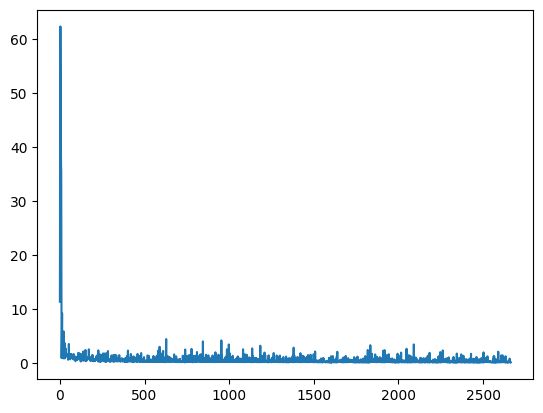

In [11]:
plt.plot(LogList)

In [12]:
total = sum(p.numel() for p in model.parameters())
print(f"{total/1e6:.2f} M params")

6.15 M params


In [13]:
model.eval()
iterative = iter(train_loader)
i,_ = next(iterative)
out = model(i.permute(0,2,1))
B,_,_ = out.shape
print(out.shape)
print(i.shape)

torch.Size([2, 320, 136])
torch.Size([2, 136, 1])


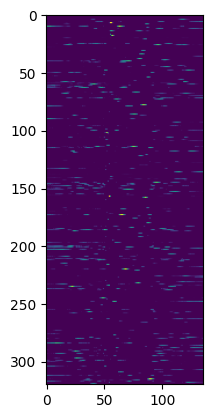

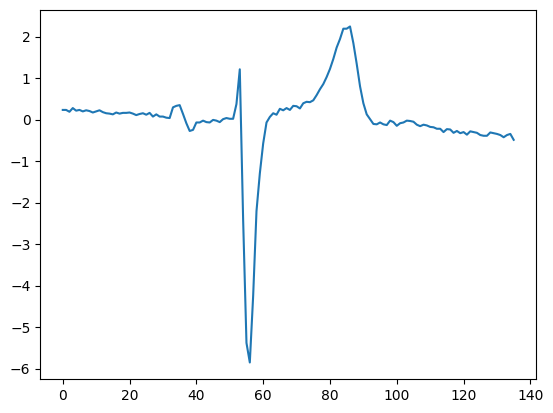

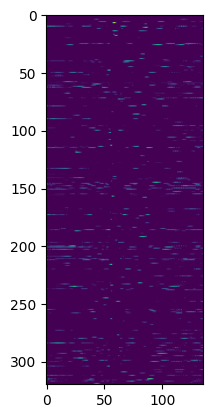

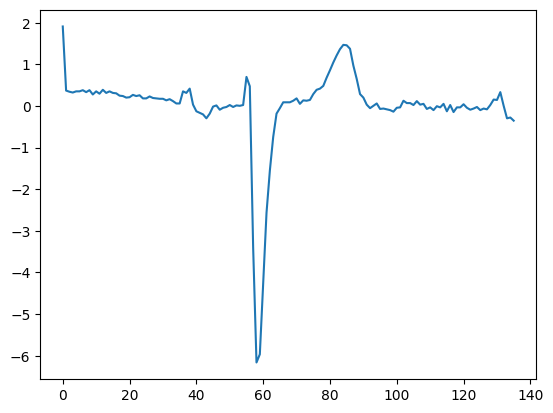

In [14]:
for j in range(B) : 
    plt.imshow(out[j].squeeze().cpu().detach())
    plt.show()
    plt.plot(i[j].view(136))
    plt.show()

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
device = 'cpu'
model.to(device)
model.eval()

def extract_representations(dataloader, model, device, pool="mean"):
    zs = []
    ys = []
    with torch.no_grad():
        for x, y in dataloader:
            # x: (B, T, 1) -> (B, 1, T)
            x = x.to(device).permute(0, 2, 1)

            r = model(x)  # (B, K, T)

            if pool == "mean":
                z = r.mean(dim=-1)      # (B, K)
            elif pool == "max":
                z = r.max(dim=-1).values
            else:
                raise ValueError("pool must be 'mean' or 'max'")

            zs.append(z.cpu())
            ys.append(y.cpu())

    Z = torch.cat(zs, dim=0).numpy()   # (N, K)
    y = torch.cat(ys, dim=0).numpy()   # (N,)
    return Z, y

# IMPORTANT : pour l’éval, on veut pas de shuffle
train_eval_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_eval_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

Z_train, y_train_np = extract_representations(train_eval_loader, model, device, pool="max")
Z_test,  y_test_np  = extract_representations(test_eval_loader,  model, device, pool="max")

print(Z_train.shape, Z_test.shape)  # ~ (23,K) et (861,K)


(23, 320) (861, 320)


In [20]:
clf = LogisticRegression(
    max_iter=1000,
    multi_class="auto"
)
clf.fit(Z_train, y_train_np)

y_pred = clf.predict(Z_test)
acc = accuracy_score(y_test_np, y_pred)
print("Test accuracy:", acc)


Test accuracy: 0.9941927990708479


/Users/rplanchon/.venvs/time-series/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
